## Evaluate different methods

**Goal:** Evaluate embedding models to match dialogs with (possibly) relevant facts  

### Constants

In [2]:
base_model_name = "BAAI/bge-base-en-v1.5"
custom_model_name = "julep-ai/dfe-base-en"
max_len = 512
batch_size = 128

### Imports and utils

In [3]:
%matplotlib inline

import hashlib, base64
from functools import partial

from beir.retrieval import models
from beir.retrieval.evaluation import EvaluateRetrieval
from beir.retrieval.search.dense import DenseRetrievalExactSearch as DRES
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import SimilarityFunction, TripletEvaluator
from tqdm.auto import tqdm

### Datasets

- for evaluation: "julep-ai/dfe-stacked_samsum" (_test_ split)

In [4]:
# Remove '#' from the dialog and remove unnecessary columns
dataset = load_dataset(
    "julep-ai/dfe-stacked_samsum", 
    split="test",
)

### Embed using base model (before tuning)

In [4]:
def embed(rows, model_name, wrap_items=False):
    from sentence_transformers import SentenceTransformer

    model = SentenceTransformer(model_name)
    
    dialogues = rows["dialogue"]
    summaries = rows["summary"]

    if wrap_items:
        dialogues = [dict(dialog=dialogue) for dialogue in dialogues]
        summaries = [dict(fact=summary) for summary in summaries]

    dialogue_embs = model.encode(dialogues).tolist()
    summary_embs = model.encode(summaries).tolist()

    return dict(
        dialogue_emb=dialogue_embs,
        summary_emb=summary_embs,
    )

In [5]:
def calc_cos_sim(row):
    dialogue_emb = row["dialogue_emb"]
    summary_emb = row["summary_emb"]

    a = np.array(dialogue_emb)
    b = np.array(summary_emb)

    cos_sim = dot(a, b)/(norm(a)*norm(b))

    return dict(similarity=cos_sim)

In [6]:
base_eval_ds = dataset.map(
    partial(embed, model_name=base_model_name),
    batch_size=batch_size, 
    batched=True,
)

Map:   0%|          | 0/18381 [00:00<?, ? examples/s]

In [7]:
base_eval_ds = base_eval_ds.map(calc_cos_sim, num_proc=100)

Map (num_proc=100):   0%|          | 0/18381 [00:00<?, ? examples/s]

### Evaluation (using base model)

1

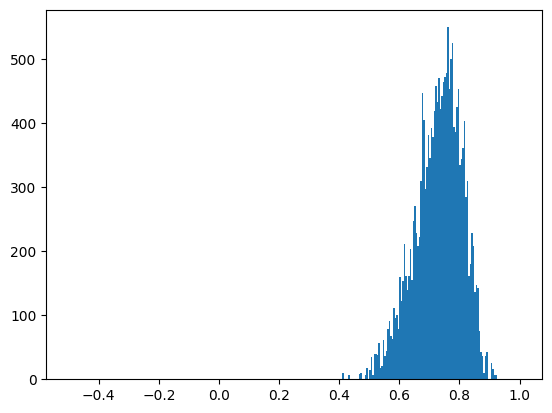

In [8]:
plt.hist(base_eval_ds["similarity"], bins=300, range=(-0.5, 1.0)); 1

### Evaluation (after tuning)

In [9]:
custom_embed = partial(embed, model_name=custom_model_name, wrap_items=True)
custom_eval_ds = dataset.map(custom_embed, batched=True, batch_size=batch_size)

Map:   0%|          | 0/18381 [00:00<?, ? examples/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [10]:
custom_eval_ds = custom_eval_ds.map(calc_cos_sim, num_proc=100)

Map (num_proc=100):   0%|          | 0/18381 [00:00<?, ? examples/s]

1

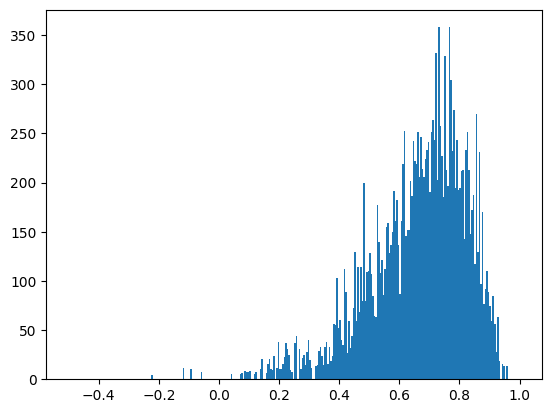

In [11]:
plt.hist(custom_eval_ds["similarity"], bins=300, range=(-0.5, 1.0)); 1

In [5]:
beir_model = DRES(models.SentenceBERT(base_model_name), batch_size=batch_size)

In [6]:
beir_retriever = EvaluateRetrieval(beir_model, score_function="cos_sim")

In [7]:
hash_str = lambda x: base64.urlsafe_b64encode(hashlib.md5(x.encode()).digest()).decode("utf-8")

In [8]:
corpus, queries, qrels = {}, {}, {}

for row in tqdm(dataset):
    dialogue = row["dialogue"]
    summary = row["summary"]
    dialogue_hash = hash_str(dialogue)
    summary_hash = hash_str(summary)

    corpus[dialogue_hash] = dict(text=dialogue)
    queries[summary_hash] = summary
    qrels[summary_hash] = {dialogue_hash: 1}

  0%|          | 0/18381 [00:00<?, ?it/s]

In [9]:
results = beir_retriever.retrieve(corpus, queries)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [11]:
ndcg, _map, recall, precision = beir_retriever.evaluate(qrels, results, beir_retriever.k_values)

In [12]:
ndcg, _map, recall, precision

({'NDCG@1': 0.12698,
  'NDCG@3': 0.48957,
  'NDCG@5': 0.51238,
  'NDCG@10': 0.52607,
  'NDCG@100': 0.54023,
  'NDCG@1000': 0.5455},
 {'MAP@1': 0.12698,
  'MAP@3': 0.38645,
  'MAP@5': 0.39921,
  'MAP@10': 0.40479,
  'MAP@100': 0.40759,
  'MAP@1000': 0.40782},
 {'Recall@1': 0.12698,
  'Recall@3': 0.79365,
  'Recall@5': 0.8486,
  'Recall@10': 0.89133,
  'Recall@100': 0.95849,
  'Recall@1000': 0.99878},
 {'P@1': 0.12698,
  'P@3': 0.26455,
  'P@5': 0.16972,
  'P@10': 0.08913,
  'P@100': 0.00958,
  'P@1000': 0.001})

In [13]:
class CustomDEModel:
    def __init__(self, model_path=None, **kwargs):
        self.model = SentenceTransformer(model_path)
    
    def encode(self, items: list[dict[str, str]], batch_size: int, **kwargs) -> np.ndarray:
        return self.model.encode(items, batch_size=batch_size, **kwargs)
        
    # query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: list[str], batch_size: int, **kwargs) -> np.ndarray:
        facts = [dict(fact=query) for query in queries]

        return self.encode(facts, batch_size=batch_size, **kwargs)
    
    # corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: list[dict[str, str]], batch_size: int, **kwargs) -> np.ndarray:
        dialogs = [dict(dialog=item["text"]) for item in corpus]

        return self.encode(dialogs, batch_size=batch_size, **kwargs)

custom_model = DRES(CustomDEModel(model_path=custom_model_name), batch_size=batch_size)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [14]:
custom_retriever = EvaluateRetrieval(custom_model, score_function="cos_sim")
custom_results = custom_retriever.retrieve(corpus, queries)

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [17]:
custom_ndcg, custom_map, custom_recall, custom_precision = custom_retriever.evaluate(qrels, custom_results, custom_retriever.k_values)
custom_ndcg, custom_map, custom_recall, custom_precision

({'NDCG@1': 0.05372,
  'NDCG@3': 0.10694,
  'NDCG@5': 0.1361,
  'NDCG@10': 0.17224,
  'NDCG@100': 0.26597,
  'NDCG@1000': 0.29186},
 {'MAP@1': 0.05372,
  'MAP@3': 0.09259,
  'MAP@5': 0.10877,
  'MAP@10': 0.12334,
  'MAP@100': 0.14103,
  'MAP@1000': 0.14203},
 {'Recall@1': 0.05372,
  'Recall@3': 0.14896,
  'Recall@5': 0.21978,
  'Recall@10': 0.33333,
  'Recall@100': 0.79121,
  'Recall@1000': 0.99389},
 {'P@1': 0.05372,
  'P@3': 0.04965,
  'P@5': 0.04396,
  'P@10': 0.03333,
  'P@100': 0.00791,
  'P@1000': 0.00099})